In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive
from ipywidgets import FloatProgress
from IPython.display import display
import scipy.spatial as ss
import scipy.stats as sst
from scipy.special import digamma,gamma
from math import log, pi, exp

# 0. Generate the 3D Lorenz Attractor as an example
You can test out other chaotic systems simply by changing the ODE function below. 

In [4]:
# Define a function for generating time-seies data given ODEs
def solve_ODE(time, ODE, state, parameters, dt=0.01):
    trajectory = np.zeros([int(time/dt), state.shape[0]])
    # Define the fourth-order Runge-Kutta method
    def rk4(ODE, state, parameters, dt):
        k1 = dt * ODE(state, parameters)
        k2 = dt * ODE(state + 0.5 * k1, parameters)
        k3 = dt * ODE(state + 0.5 * k2, parameters)
        k4 = dt * ODE(state + k3, parameters)
        return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    for i in range(int(time/dt)):
        state = rk4(ODE, state, parameters,dt)
        trajectory[i,:] = state
    return trajectory

# Define ODEs for Lorenz Attractor
def lorenz_ode(state, parameters):
    x, y, z = state
    sigma, beta, rho = parameters
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

# Now putting it together, define a function for generating lorenz systems given initial state and parameters
def lorenz(time, x0, y0, z0, sigma, beta, rho):
    state = np.array([x0,y0,z0])
    parameters = np.array([sigma, beta, rho])
    trajectory = solve_ODE(time, lorenz_ode, state, parameters)
    fig = plt.figure()
    axe = fig.gca(projection='3d')

    x, y, z = trajectory[:,0],trajectory[:,1],trajectory[:,2]
    lines = axe.plot(x, y, z, lw=0.5)
    plt.show()
    return trajectory

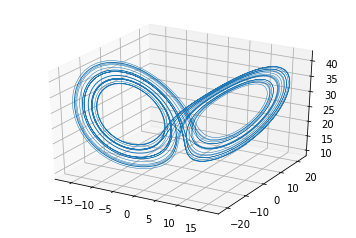

In [5]:
lorenz_trajectory = lorenz(2**5, -8.0, 9.0, 20.0, 10.0, 8/3.0, 28.0)

You can play with the parameters and the initial inputs:

In [6]:
w = interactive(lorenz, time=(0,2**5), x0=-8, y0=9, z0=20, sigma=10, beta=4, rho=30)
display(w)

interactive(children=(IntSlider(value=16, description='time', max=32), IntSlider(value=-8, description='x0', max=8, min=-24), IntSlider(value=9, description='y0', max=27, min=-9), IntSlider(value=20, description='z0', max=60, min=-20), IntSlider(value=10, description='sigma', max=30, min=-10), IntSlider(value=4, description='beta', max=12, min=-4), IntSlider(value=30, description='rho', max=90, min=-30), Output()), _dom_classes=('widget-interact',))

# 1. Select the appropriate time delay for state space reconstruction

We use time lagged variables to form coordinates for the reconstructed phase space. Our goal is to identify a delayed measure which would give us as much new information about the evolution of the system as possible. Fraser proposes a good delay would be when the mutual information between $s(t)$ and $s(t+T)$ reaches its first local minimum [2]

## 1.1 Mutual information estimator

First we need to build a mutual information estimator. There are numerous methods aimming at correcting the bias which would arises from naively pluging in frequency distributions of the samples as the underlying probabiliy distribution Here I choose Kraskov's K-nearest-neighbor estimator as it has been shown to be stable and less affected by parameters especially for time series from nonlinear dynamical systems <https://arxiv.org/pdf/cond-mat/0305641.pdf>; <https://arxiv.org/pdf/0809.2149.pdf>.

Below is the code I wrote using the second algorithm proposed by the Kraskov paper.

First, for one dimensional data: 

In [6]:
def MI_plugin(x, y, base = 2):
    bins = np.ceil(np.log2(len(x)))+1
    histgram, x_edges, y_edges = np.histogram2d(x, y, bins = bins)
    Pxy = histgram / float(np.sum(histgram))
    Px = np.sum(Pxy, axis=1)  # Get the marginal probability of x by summing over y
    Py = np.sum(Pxy, axis=0)  # Get the marginal probability of y by summing over x
    PxPy = Px[:, None] * Py[None, :]
    non_zero = Pxy > 0 # Only non-zero Pxy terms contribute to the sum
    return np.sum(Pxy[non_zero] * np.log2(Pxy[non_zero] / PxPy[non_zero]))

In [5]:
def MI_knn_1D(x,y, k=3, base=2):
    # Input functions:
    #     X, Y: array_like, shape (n,). Both inputs are n samples of data points with one feature
    #     k: the number of nearest neighbour
    #     base: log base
    # output function: 
    #     MI_estimate: Mutual Information estimate using the second algorithm proposed by the Kraskov paper
    # Kraskov, Stogbauer, and Grassberger, "Estimating mutual information", Physical review E 69, no. 6 (2004): 066138.
    N = len(x)   # sample size
    nx = np.zeros(N)
    ny = np.zeros(N)
    x = np.expand_dims(x, axis=1)
    y = np.expand_dims(y, axis=1)
    x_y = np.concatenate((x,y),axis=1)
    tree_xy = ss.cKDTree(x_y)
    tree_x = ss.cKDTree(x)
    tree_y = ss.cKDTree(y)
    for i in range(N):
        knn_idx = tree_xy.query(x_y[i],k+1,p=float('inf'))[1][k]
        knn = tree_xy.data[knn_idx]
        epsX = np.absolute(knn[0]-x[i])
        epsY = np.absolute(knn[1]-y[i])
        nx[i] = len(tree_x.query_ball_point(x[i], epsX, p=2))
        ny[i] = len(tree_y.query_ball_point(y[i], epsY, p=2))
    MI_estimate = (digamma(k) - 1/float(k) - (sum(list(map(digamma, nx)) 
        + list(map(digamma, ny))) / N)+ digamma(N) ) / np.log(base)
    return MI_estimate

## 1.2 Plot MI against time delay

We find mutual information as a function of time delay, and locate the time delay when mutual information reaches it first minimum.

In [7]:
def MI_tau(time_series, dt, code=MI_knn_1D,tau_number=40):
    # Input functions: 
    #     time_series: shape (n_samples, n_features). n_samples is the number of points in the time series, 
    #     and n_features is the dimension of the parameter space.array_like, shape (n,m). The time series to be unfolded
    #     code: MI_knn_1D or MI_knn_multiD. For one dimensional data, both codes give same result, but MI_knn_1D runs much faster, 
    #     becuase it uses KDTree to find nearest neighbor.  
    #     tau_number: the number of time delays for which to estimate mutual information
    #     dt: the time duration between two sample points in the time series
    # Output functions:
    #     mi, tau: mi(tau) is the estimated mutual information between the time series at [0,t_total - tau] and [tau, t_total]
    N = len(time_series)
    mi = np.zeros(tau_number)  
    tau = np.zeros(tau_number)
    #f = FloatProgress(min=0, max=tau_number) # instantiate the progress bar
    #display(f) # display the bar
    for i in range(0, tau_number): 
        mi[i] = code(time_series[:N-1-i],time_series[i+1:])
        tau[i]=(i+1)*dt
        #f.value += 1
    return tau, mi

Let's try plug in x(t) of the 3D Lorenz system:

Text(0.5,0.98,'lorenz_x')

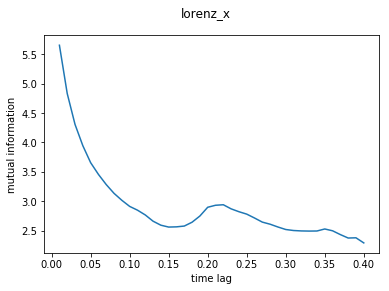

In [8]:
%matplotlib inline
lorenz_x = lorenz_trajectory[:,0]
tau_x,mi_lorenz_x = MI_tau(lorenz_x, 0.01, MI_knn_1D)
plt.plot(tau_x, mi_lorenz_x)
plt.xlabel("time lag")
plt.ylabel("mutual information")
plt.suptitle('lorenz_x')

In [9]:
from scipy.signal import argrelextrema
def lcmin_1_2(data, order=1):
    # Find the indice for the first and the second local minimum
    # Inputs:
    #     data: array (n,)
    #     order: how many points on each side to use for the comparison 
    # Output:
    #     lcmin_1, lcmin_2: indice for the first and the second local minimum
    lcmin_1 = argrelextrema(data, np.less, order=order)[0][0]
    lcmin_2 = argrelextrema(data, np.less, order=order)[0][1]
    return lcmin_1, lcmin_2

In [10]:
lcmin_1, lcmin_2= lcmin_1_2(mi_lorenz_x)
print(lcmin_1, lcmin_2)

14 32


# 2. Choosing the dimension of Reconstructed Phase Space

Now that we have chosen a time delay, we are ready to see how the time series look like in a d-dimensional state space with coordinates: $y(k) = [S(k), S(k+T),..., S(k+(d-1)T)]$

First we find the points in the reconstructed spaces: 

In [11]:
def reconstruct(data, T_index, samplerate = 1, d_max = 8):
    # Inputs:
    #     data: time series, (n, 1) narray  
    #     lcmin_index: the index for the time delay selected
    #     sample: the number of data points to use for reconstruction. See Abarbanel P. 49. Oversampling needs to be avoided.
    #     samplerate: take 1 data point for every 'samplerate' data points when reconstructing the state space
    #     d_max: do the reconstruction for [1, d_max] dimensions
    # Output: 
    #     reconstru_vectors: a list of length (d_max-1) containing points in the reconstructed [2, d_max] dimensional state space
    sample = len(data) - (d_max-1)*T_index
    print(sample)
    reconstru_vectors = []
    for d in range(1, d_max+1):
        reconstru_vectors_d = np.zeros((sample, d)) 
        for i in range(0, sample):
            k = i*samplerate
            reconstru_vectors_d[i] = data[k:k+(d-1)*T_index+1:T_index]
        reconstru_vectors.append(reconstru_vectors_d)
    return reconstru_vectors

In [38]:
reconstru_lorenz_x_1 = reconstruct(lorenz_x, 15, d_max=10)

3065


If we try plot the lorenz x measures in 2 dimension space, we will see that the attractor is mostly unfolded but the trajectory still overlaps with itself at some point. It makes sense that the lorenz attractor can nearly be fully unfolded in dimension 2 because its fractal dimension is 2.06:

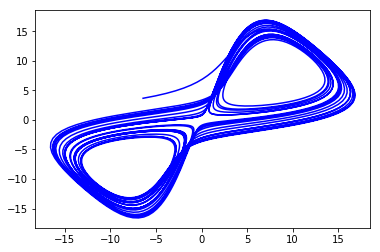

In [39]:
% matplotlib inline
plt.figure()
plt.plot(reconstru_lorenz_x_1[1][:,0],reconstru_lorenz_x_1[1][:,1], color='blue')
plt.show()

Plot the time series lorenz_x reconstructed in 3D space, using the first local minimum time delay:

In [40]:
def plot_3D(data):
    # plot narray data of shape (n, 3) in 3D space
    fig = plt.figure()
    axe = fig.gca(projection='3d')
    axe.plot(data[:,0], data[:,1],data[:,2],lw=0.5)
    plt.show()

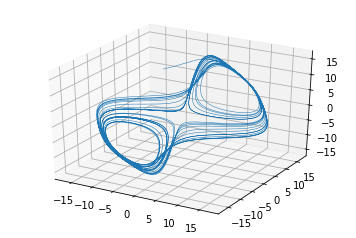

In [41]:
plot_3D(reconstru_lorenz_x_1[2]) # vectors for reconstructed 3D space were put into index[1], for 4D space were put into [2].... 

Try plotting the time series lorenz_x in 3D space using the second local minimum:

3050


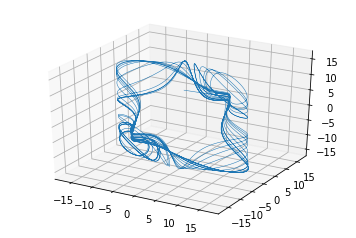

In [45]:
reconstru_lorenz_x_2 = reconstruct(lorenz_x, 30, d_max=6)
plot_3D(reconstru_lorenz_x_2[2])

In a chaotic system any measurement stripe will eventually spread back to the invariant measure. To avoid this kind of spreading, as can be seen in the second graph, the first local minimum would be more preferable than the second minimum.  
We determine the minimal dimension needed to fully unfold the attractor by counting the number of global false nearest neighbors:

In [46]:
def fnn(data, reconstru, A = 2, threshold=15):
    # Find the percentage of false nearst neighbor in dimension d 
    # Inputs: 
    #    data: the original time series
    #    reconstru: vectors in reconstructed state space
    #    d_max: do the calculation for [1, d_max-1] dimensions. 
    #           The max dimension we can get to here has to be one less than d_max for the previous step  
    #           because we have to go one dimension up to define false/truth nearest neighbors
    #    threshold: Abarbanel says that 15 would work (Abarbanel, P. 41)
    # Output: the percentage of false nearest neighbor in dimensions [1, d_max]

    # find the nearest neighbor points in dimension [1, d_max+1], 
    # and calculate the Euclidian distance between them and the original points
    
    d_max = len(reconstru)
    numerator = []
    R = []
    fnn_percentage = []
    for d in range(1, d_max):
        reconstru_d = reconstru[d-1] 
        reconstru_d_plus1 = reconstru[d]
        tree = ss.cKDTree(reconstru_d)
        ii = tree.query(reconstru_d, k = [2], p=float('inf'))[1]
        ii = np.squeeze(ii)
        reconstru_d_NN = reconstru_d[ii]  # find the nearest neighbors 
        reconstru_d_plus1_NN = reconstru_d_plus1[ii]
        numerator_d = abs(reconstru_d_plus1[:,-1] - reconstru_d_plus1_NN[:,-1])
        R_d = np.linalg.norm(reconstru_d - reconstru_d_NN, axis = 1) # Euclidian distance
        fnn_1 = numerator_d / (R_d+1e-15) > threshold
        fnn_2 = numerator_d / np.std(data) > A
        fnn_d = fnn_1 | fnn_2
        fnn_pct_d = np.mean(fnn_d)
        fnn_percentage.append(fnn_pct_d)
    plt.figure()
    plt.plot(range(1,len(fnn_percentage)+1), fnn_percentage, 'bo-')
    plt.title(r'FNN for time series')
    plt.xlabel(r'Embedding dimension $d$')
    plt.show()
    return np.array(fnn_percentage).T

In [47]:
def fnn_Cao(reconstru):
    # Find the percentage of false nearst neighbor in dimension d 
    # Inputs: 
    #    reconstru: vectors in reconstructed state space
    #    d_max: do the calculation for [1, d_max-2] dimensions. 
    #           The max dimension we can get to here has to be two less than d_max for the previous step  
    #           because we have to go one dimension up to define false/truth nearest neighbors, and one more up to find E1, E2 
    # Output: the percentage of false nearest neighbor in dimensions [1, d_max]-2

    # find the nearest neighbor points in dimension [1, d_max], 
    # and calculate the Euclidian distance between them and the original points
    d_max = len(reconstru)
    E = []
    Es = []
    E1 = []
    E2 = []
    for d in range(1, d_max):
        tau = 27
        # reconstru_d = utils.reconstruct(mg[:-tau], d, tau)
        # reconstru_d_plus1 = utils.reconstruct(mg, d + 1, tau)
        reconstru_d = reconstru[d-1] 
        reconstru_d_plus1 = reconstru[d]
        tree = ss.cKDTree(reconstru_d)
        dd, ii = tree.query(reconstru_d, k = [2], p=float('inf'))
        ii = np.squeeze(ii)
        dd = np.squeeze(dd)
        reconstru_d_NN = reconstru_d[ii]  # find the nearest neighbors 
        #reconstru_d_NN = [reconstru_d[tree.query(y, k = [3], p=float('inf'))[1]] if np.all(x==y) else x 
                       #   for x, y in list(zip(reconstru_d_NN, reconstru_d))] 
        # take the second nearest neighbor if the first nearst neighbor equals the original point
        reconstru_d_NN = np.vstack(reconstru_d_NN)
        reconstru_d_plus1_NN = reconstru_d_plus1[ii]
        Es_d = np.mean(abs(reconstru_d_plus1[:,-1] - reconstru_d_plus1_NN[:,-1]))
        R_d_plus1 = np.amax(abs(reconstru_d_plus1 - reconstru_d_plus1_NN), axis = 1) # Maximum norm  
        a_i_d = R_d_plus1/(dd+1e-15)
        E_d = np.mean(a_i_d)
        E.append(E_d)
        Es.append(Es_d)
    for d in range(1, d_max-1):
        E1_d = E[d]/E[d-1]
        E2_d = Es[d]/Es[d-1]
        E1.append(E1_d)
        E2.append(E2_d)
    plt.figure()
    plt.plot(range(1,len(E1)+1), E1, 'bo-', label=r'$E_1(d)$')
    plt.plot(range(1,len(E1)+1), E2, 'go-', label=r'$E_2(d)$')
    plt.title(r'AFN for time series')
    plt.xlabel(r'Embedding dimension $d$')
    plt.ylabel(r'$E_1(d)$ and $E_2(d)$')
    plt.legend()
    plt.show()
    return np.array(E1), np.array(E2)

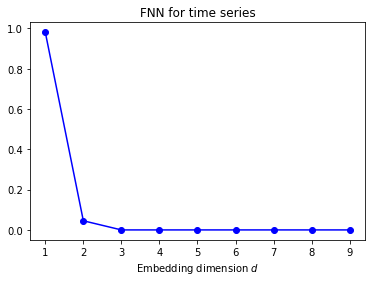

array([0.98140294, 0.04535073, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [48]:
fnn(lorenz_x, reconstru_lorenz_x_1)

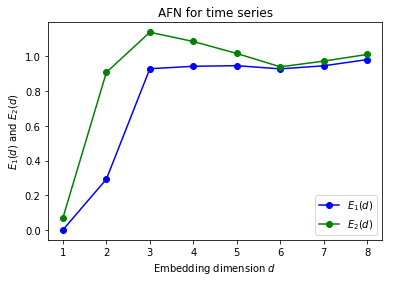

(array([1.15226236e-04, 2.92667375e-01, 9.29114296e-01, 9.43261806e-01,
        9.46648770e-01, 9.28403032e-01, 9.46075408e-01, 9.81874202e-01]),
 array([0.06925954, 0.90807211, 1.13945518, 1.08613852, 1.0170986 ,
        0.94017345, 0.97299488, 1.01169999]))

In [49]:
fnn_Cao(reconstru_lorenz_x_1)

References:
[1] Abarbanel, H. (2012). Analysis of observed chaotic data. Springer Science & Business Media.
[2] Fraser, A. M., & Swinney, H. L. (1986). Independent coordinates for strange attractors from mutual information. Physical review A, 33(2), 1134.
[3] Cao, Liangyue. "Practical method for determining the minimum embedding dimension of a scalar time series." Physica D: Nonlinear Phenomena 110.1-2 (1997): 43-50.